# Hotel price exloratory data analysis (EDA)

- This notebook will present the results from analyzing more than 1000 hotels from the website Booking.com
- Target variable: Price (int)
- Feature variables:
    - Name: string
    - Address: string
    - Size: int
    - Distance to beach: float
    - Distance to airport: float
    - Pool: boolean
    - Car: boolean
    - Non-smoking room: boolean
    - Near beach: boolean
    - WiFi: boolean
    - Family room: boolean
    - Bar: boolean
    - Breakfast: boolean

# Import modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')

# Load data

In [2]:
data = pd.read_csv("../raw data/raw_data_train.csv")
dtest = pd.read_csv("../raw data/raw_data_test.csv")

# Data cleaning

- Remove "VND" from Price column, convert it to int and scale down by 1000 for later analysis

In [3]:
def convert(data):
    return int(data.split()[1].replace(".",""))

def scale(data):
    return round(data/1000)

In [4]:
data["Price"] = data["Price"].apply(lambda x: scale(convert(x)))
dtest["Price"] = dtest["Price"].apply(lambda x: scale(convert(x)))
data["Type"] = data["Price"].apply(lambda x: 0 if x<1500 else (1 if x < 5000 else 2))
dtest["Type"] = dtest["Price"].apply(lambda x: 0 if x<1500 else (1 if x < 5000 else 2))

- In 3 columns Price, Size, Distance to beach, the medians are much smaller than the means => The distributions of these features are left-skewed
- Maximum value of Price, Size and Distance to beach are much larger than its q3 value => These 3 variables contain a lot of outliers in its right tails
- For Distance to airport, its minimum is much smaller than its q1 value => Its distribution contains many outliers in both tails

# Univariate plotting

In [5]:
sns.set_style("dark")

## 1. Data distribution of Price

Text(0.5, 0, 'Price (Thousand VND)')

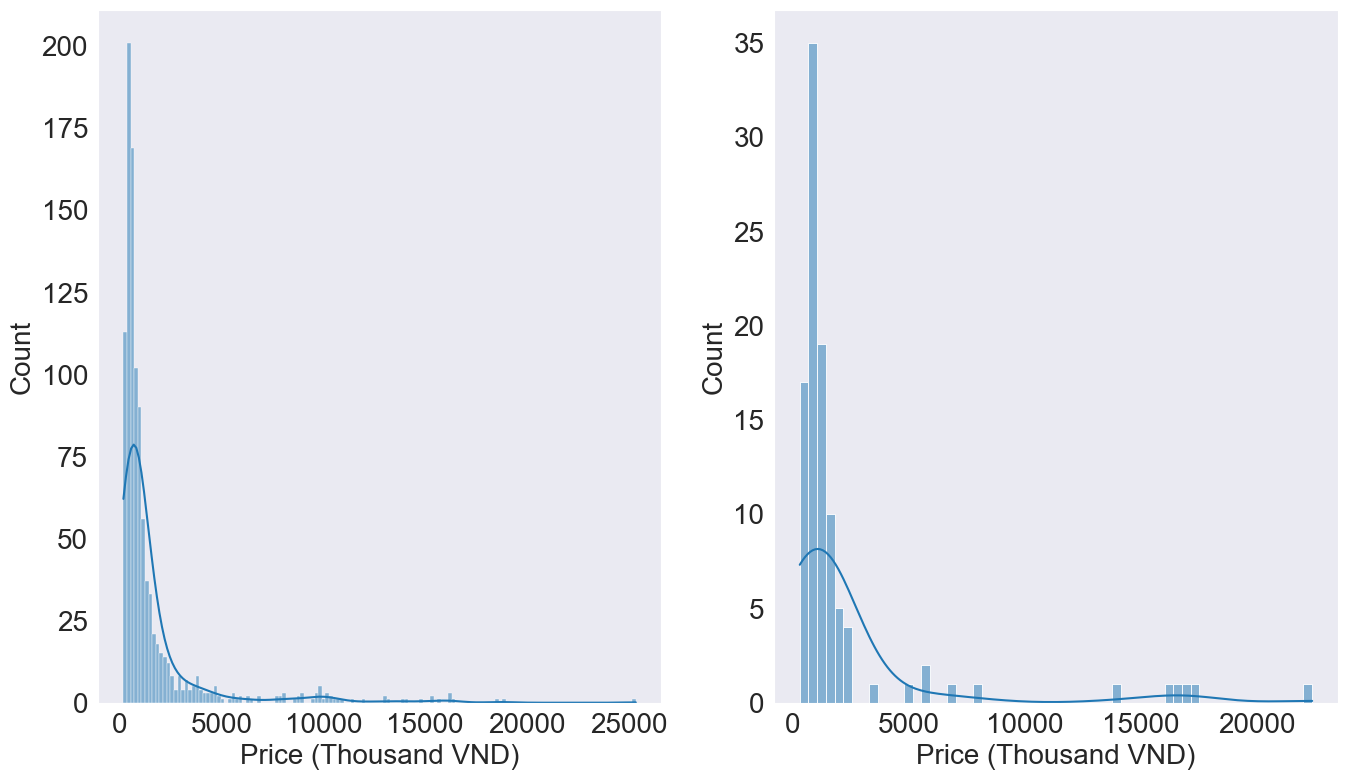

In [6]:
fig = plt.figure(figsize = (16, 9))
plt.rcParams.update({'font.size': 20})
gs = gridspec.GridSpec(1, 2)

prices = fig.add_subplot(gs[0, 0])
sns.histplot(data=data["Price"], ax = prices, kde = True)
prices.set_xlabel('Price (Thousand VND)')
prices = fig.add_subplot(gs[0, 1])
sns.histplot(data=dtest["Price"], ax = prices, kde = True)
prices.set_xlabel('Price (Thousand VND)')

- The majority of room prices fall in the range of 250,000 VND - 1,250,000 VND
- However, there are still many outliers, perhaps due to the existence of luxury hotels with high-end room classes
- Data distribution in both the train set and test set are similar

## 2. Data distribution of other features

 - Here, we will plot the distribution of the features Size, Distance to beach, and Distance to airport to verify the observations mentioned above

Text(0.5, 0, 'Size (m2)')

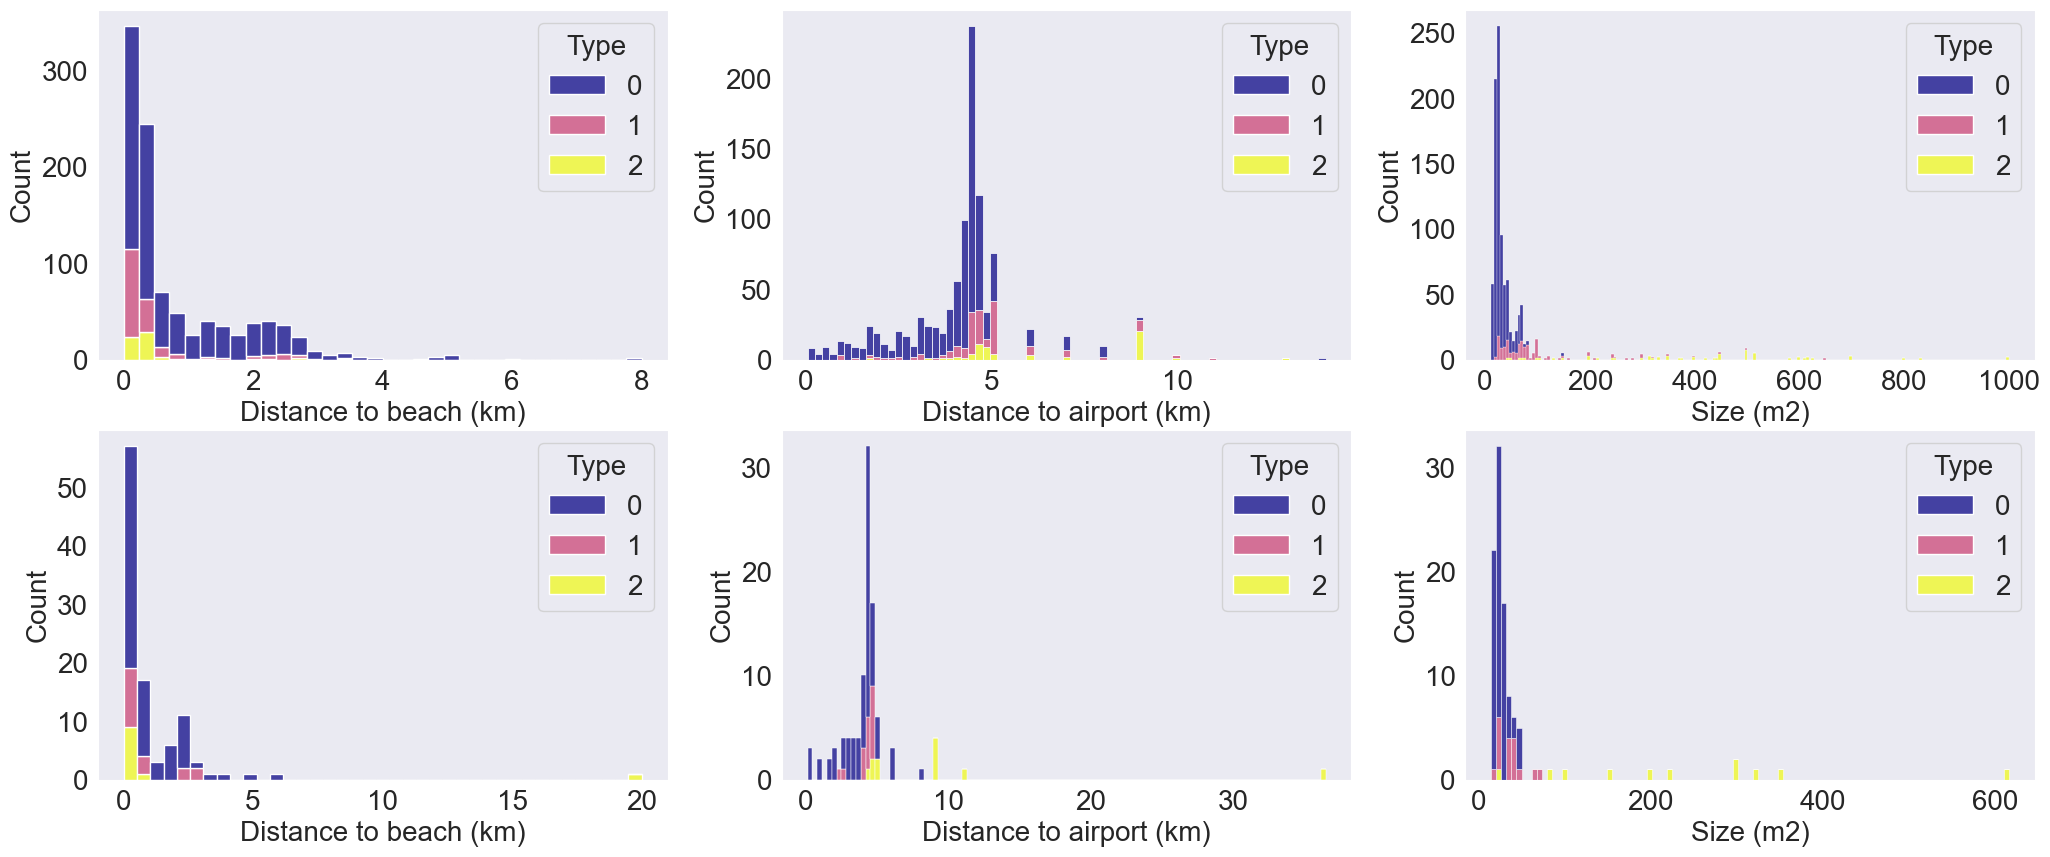

In [8]:
fig = plt.figure(figsize = (25, 10))
gs = gridspec.GridSpec(2, 3)
plt.rcParams.update({'font.size': 20})


distance_beach = fig.add_subplot(gs[0, 0])
sns.histplot(data=data, x="Distance to beach", ax=distance_beach,  hue="Type", palette="plasma", multiple="stack")
distance_beach.set_xlabel("Distance to beach (km)")

distance_airport = fig.add_subplot(gs[0, 1])
sns.histplot(data=data, x = "Distance to airport", ax = distance_airport,  hue="Type", palette="plasma", multiple="stack")
distance_airport.set_xlabel("Distance to airport (km)")

sizes = fig.add_subplot(gs[0, 2])
sns.histplot(data=data, x = "Size", ax = sizes,  hue="Type", palette="plasma", multiple="stack")
sizes.set_xlabel("Size (m2)")

distance_beach = fig.add_subplot(gs[1, 0])
sns.histplot(data=dtest, x = "Distance to beach", ax = distance_beach, hue="Type", palette="plasma", multiple="stack")
distance_beach.set_xlabel("Distance to beach (km)")

distance_airport = fig.add_subplot(gs[1, 1])
sns.histplot(data=dtest, x = "Distance to airport", ax = distance_airport, hue="Type", palette="plasma", multiple="stack")
distance_airport.set_xlabel("Distance to airport (km)")

sizes = fig.add_subplot(gs[1, 2])
sns.histplot(data=dtest,x = "Size", ax = sizes, hue="Type", palette="plasma", multiple="stack")
sizes.set_xlabel("Size (m2)")


- It can be seen that the majority of hotels are built near the beach rather than the airport

## 

Text(0, 0.5, 'Price (Thousand VND)')

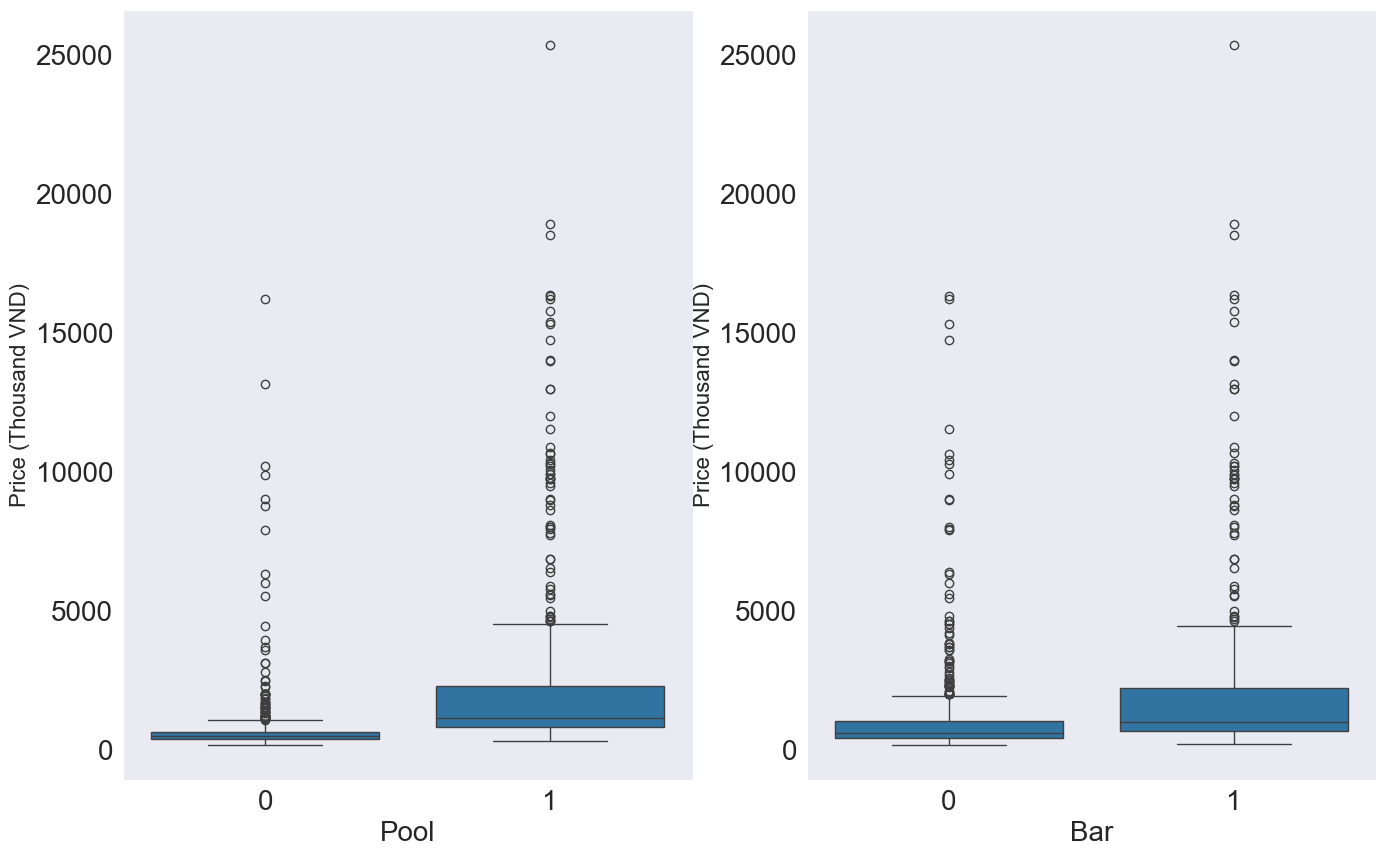

In [15]:
fig = plt.figure(figsize = (25, 10))
gs = gridspec.GridSpec(1, 3)

sns.boxplot(data=data, x ="Pool", y = "Price", ax = fig.add_subplot(gs[0,0]))
plt.ylabel('Price (Thousand VND)', fontsize = 16)
sns.boxplot(data=data, x ="Bar", y = "Price", ax = fig.add_subplot(gs[0,1]))
plt.ylabel('Price (Thousand VND)', fontsize = 16)

- It seems like hotels with pools and bars tend to have more expensive rooms.


## 3. Remove outliers

- Assign the values not in range [q1 - 2.5*iqr; q3 + 2.5*iqr] to its nearest boundaries (Capping)


In [20]:
def change_outlier(data, column):
    q1, q3 = np.percentile(data[column], [25, 75])
    iqr = q3 - q1
    lower_bridge = q1 - (iqr * 2.5)
    upper_bridge = q3 + (iqr * 2.5)
    for i in range(len(data[column])):
        if data[column].iloc[i] <= lower_bridge:
            data[column].iloc[i] = lower_bridge
        elif data[column].iloc[i] >= upper_bridge:
            data[column].iloc[i] = upper_bridge

- Perform capping on 4 variables

In [21]:
cols = ["Size", "Distance to beach", "Distance to airport"]

for col in cols:
    change_outlier(data, col)
    change_outlier(dtest, col)
data.describe()

,Price,Size,Distance to beach,Distance to airport,Pool,Car,Non-smoking room,Near beach,WiFi,Family room,Bar,Breakfast,Type
count,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000
mean,1584.800198,41.975272,0.827502,4.096934,0.492582,0.538081,0.804154,0.386746,0.906034,0.787339,0.376855,0.019782,0.284866
std,2606.333161,30.205212,0.949144,1.337243,0.500192,0.498794,0.397047,0.487246,0.291926,0.409392,0.484838,0.139321,0.571569
min,177.000000,12.000000,0.007000,1.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,484.000000,22.000000,0.150000,3.600000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,744.000000,28.000000,0.350000,4.400000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1379.000000,50.000000,1.350000,4.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,25347.000000,120.000000,4.350000,7.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


## Other features distribution after capping

Text(0.5, 0, 'Size (m2)')

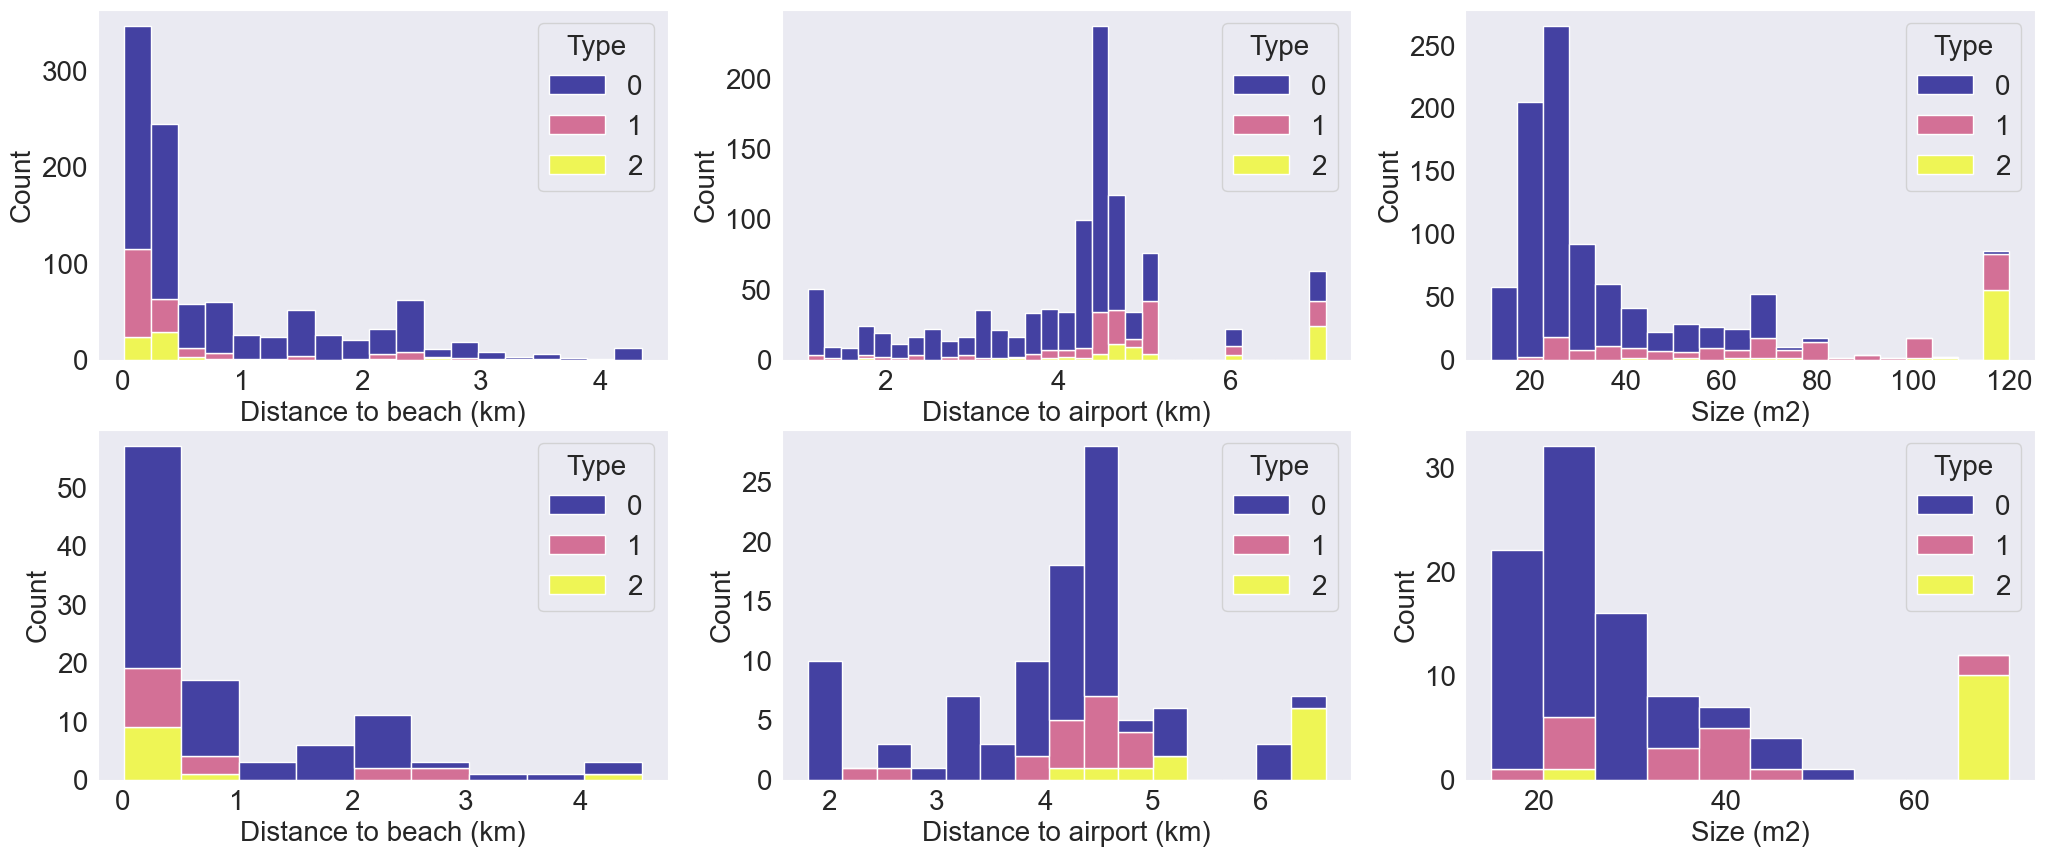

In [22]:
fig = plt.figure(figsize = (25, 10))
gs = gridspec.GridSpec(2, 3)
plt.rcParams.update({'font.size': 20})


distance_beach = fig.add_subplot(gs[0, 0])
sns.histplot(data=data, x="Distance to beach", ax=distance_beach,  hue="Type", palette="plasma", multiple="stack")
distance_beach.set_xlabel("Distance to beach (km)")

distance_airport = fig.add_subplot(gs[0, 1])
sns.histplot(data=data, x = "Distance to airport", ax = distance_airport,  hue="Type", palette="plasma", multiple="stack")
distance_airport.set_xlabel("Distance to airport (km)")

sizes = fig.add_subplot(gs[0, 2])
sns.histplot(data=data, x = "Size", ax = sizes,  hue="Type", palette="plasma", multiple="stack")
sizes.set_xlabel("Size (m2)")

distance_beach = fig.add_subplot(gs[1, 0])
sns.histplot(data=dtest, x = "Distance to beach", ax = distance_beach, hue="Type", palette="plasma", multiple="stack")
distance_beach.set_xlabel("Distance to beach (km)")

distance_airport = fig.add_subplot(gs[1, 1])
sns.histplot(data=dtest, x = "Distance to airport", ax = distance_airport, hue="Type", palette="plasma", multiple="stack")
distance_airport.set_xlabel("Distance to airport (km)")

sizes = fig.add_subplot(gs[1, 2])
sns.histplot(data=dtest,x = "Size", ax = sizes, hue="Type", palette="plasma", multiple="stack")
sizes.set_xlabel("Size (m2)")



Outliers have been removed, making visualization easier. 

Text(0, 0.5, 'Price (Thousand VND)')

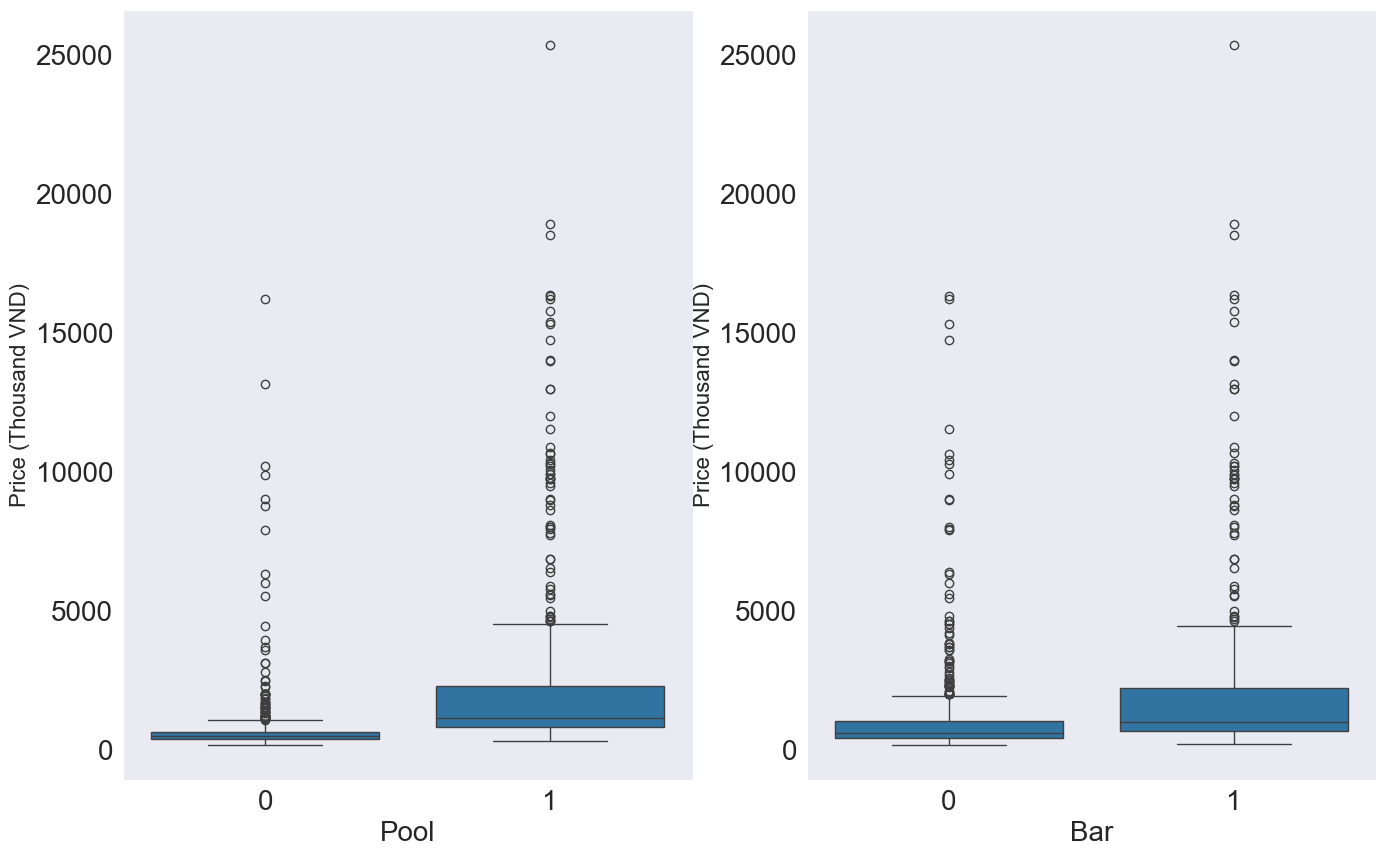

In [23]:
fig = plt.figure(figsize = (25, 10))
gs = gridspec.GridSpec(1, 3)

sns.boxplot(data=data, x ="Pool", y = "Price", ax = fig.add_subplot(gs[0,0]))
plt.ylabel('Price (Thousand VND)', fontsize = 16)
sns.boxplot(data=data, x ="Bar", y = "Price", ax = fig.add_subplot(gs[0,1]))
plt.ylabel('Price (Thousand VND)', fontsize = 16)

Outliers have been removed, making visualization easier.
Hotels with pools and hotels with bars have an average price significantly higher than hotels without these two services.

# Multivariate Plotting

## Correlation map

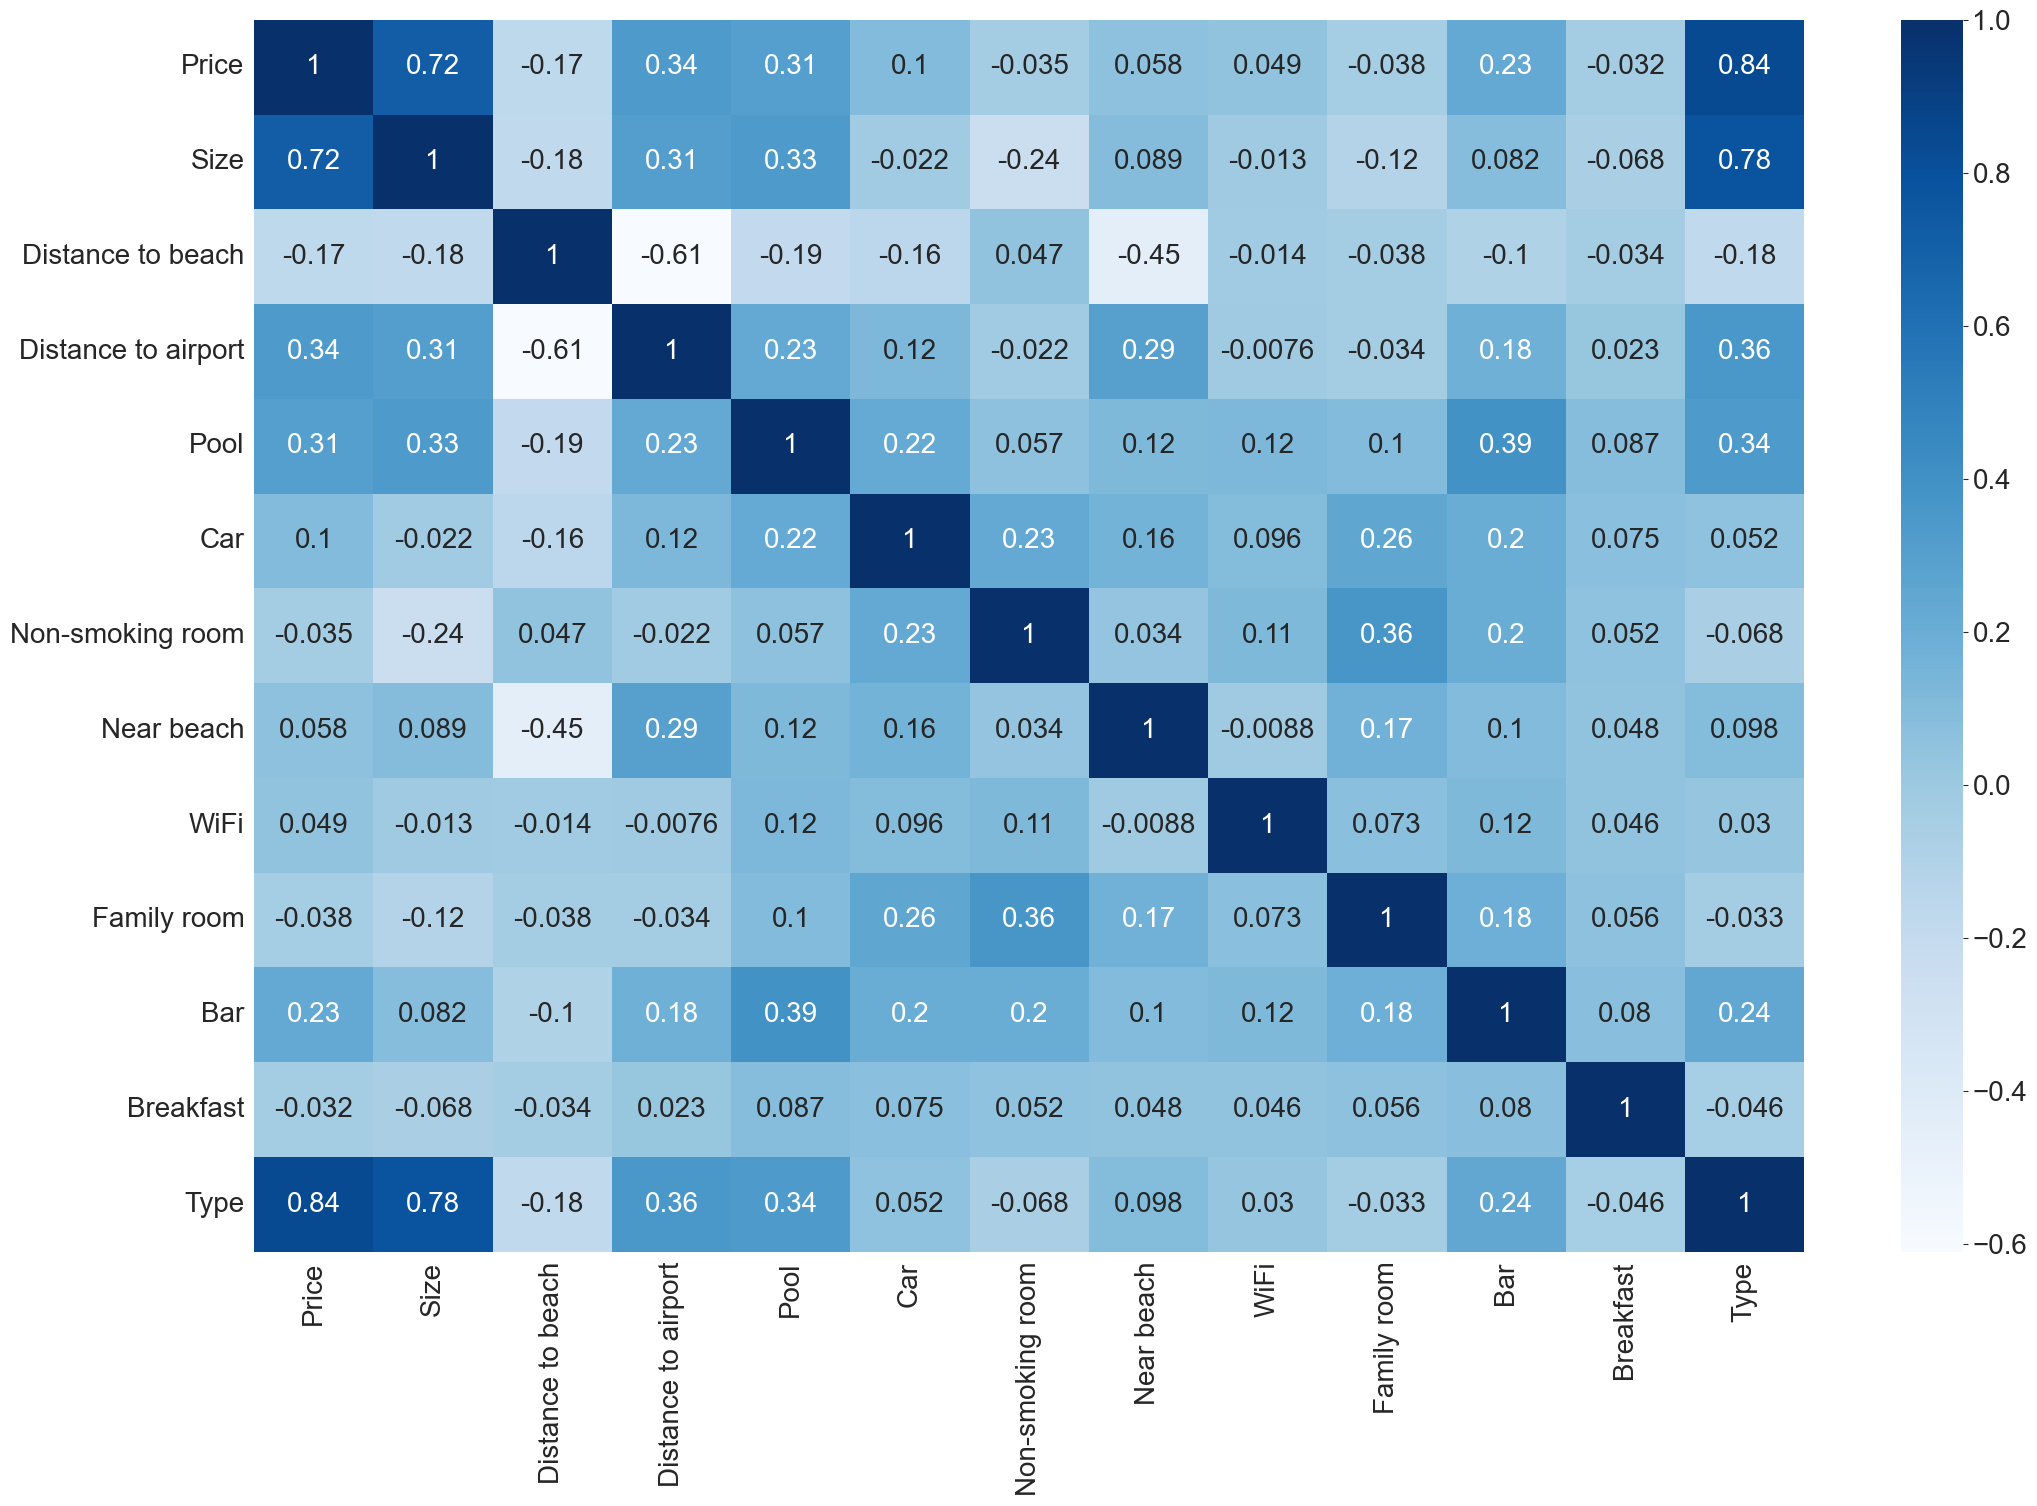

In [24]:
plt.figure(figsize = (25, 16))

numeric_data = data.select_dtypes(include=[np.number])
dataplot = sns.heatmap(numeric_data.corr(), annot = True, cmap= "Blues")

- It can be seen that:
    - Size has a strong positive correlation with Price (0.82)
    - In addition, some other features like: Distance to beach, Distance to airport, Pool, Bar also have impact on Price


Text(0, 0.5, 'Price (Thousand VND)')

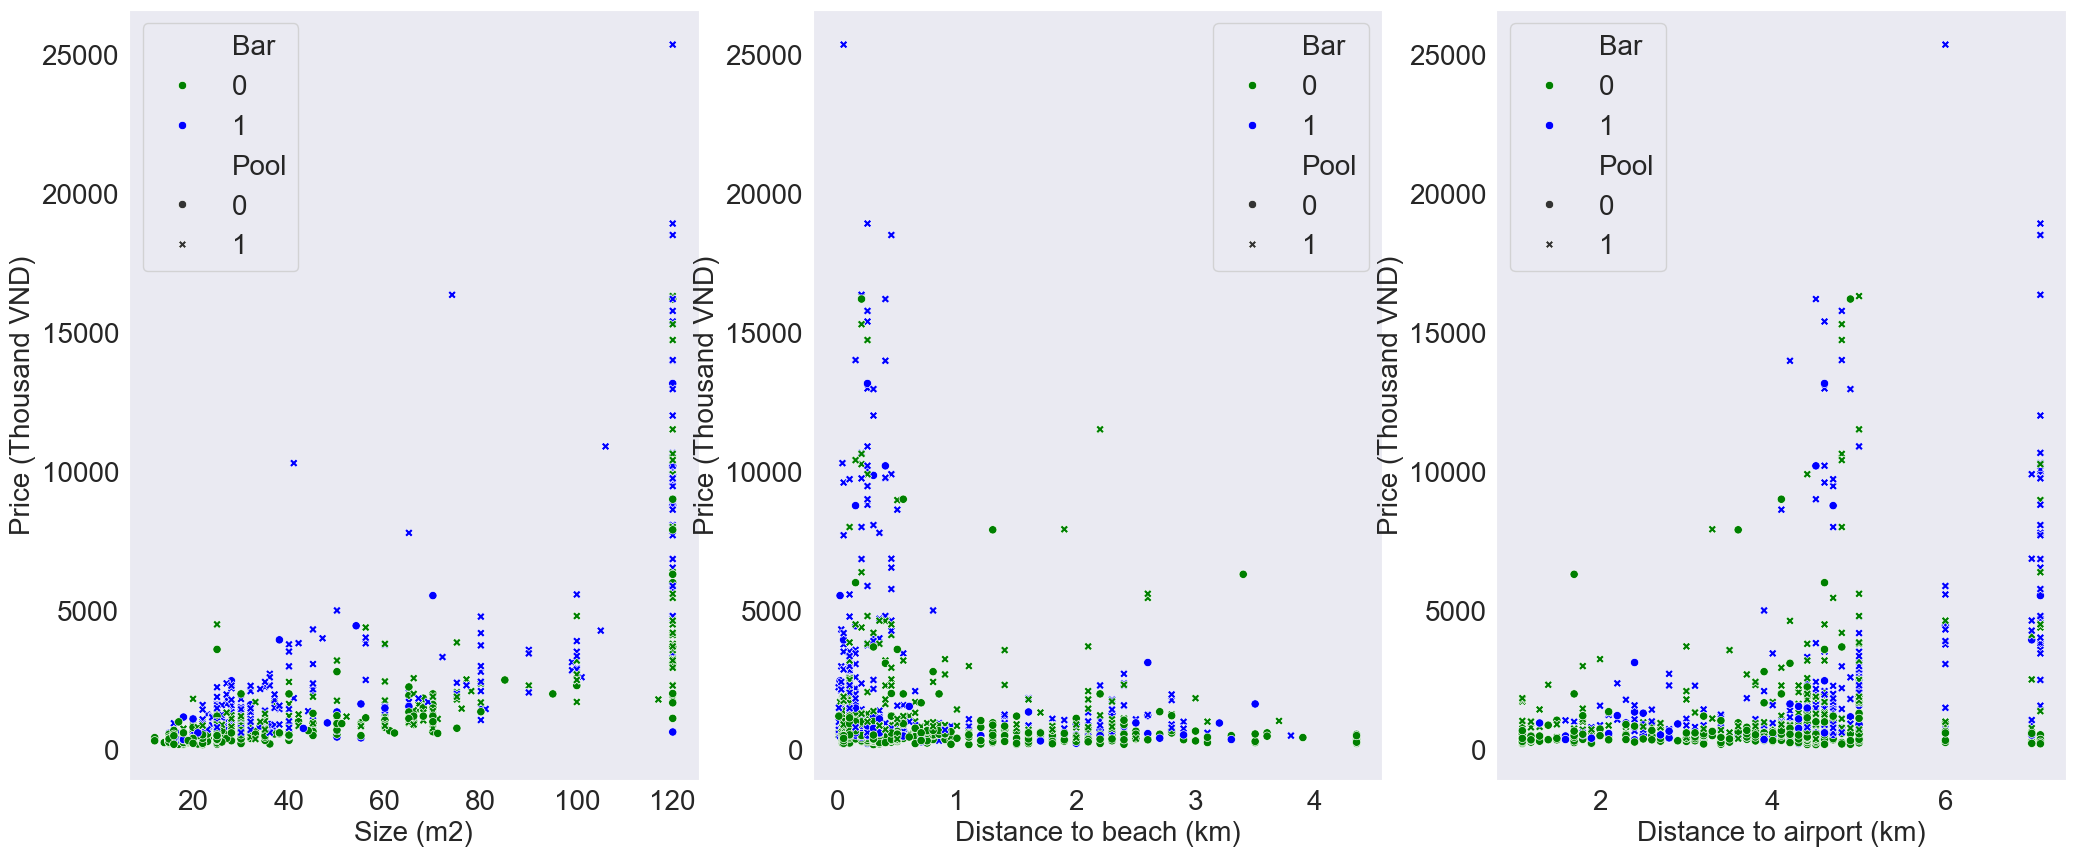

In [25]:
fig = plt.figure(figsize = (25, 10))
gs = gridspec.GridSpec(1, 3)

pool = fig.add_subplot(gs[0, 0])
sns.scatterplot(data = data, x = "Size", y = "Price", hue = "Bar", style = "Pool", palette=["g", "b"], ax = pool)
pool.set_xlabel("Size (m2)")
pool.set_ylabel("Price (Thousand VND)")

bar = fig.add_subplot(gs[0, 1])
sns.scatterplot(data = data, x = "Distance to beach", y = "Price", hue = "Bar", style = "Pool", palette=["g", "b"], ax = bar)
bar.set_xlabel("Distance to beach (km)")
bar.set_ylabel("Price (Thousand VND)")

bar = fig.add_subplot(gs[0, 2])
sns.scatterplot(data = data, x = "Distance to airport", y = "Price", hue = "Bar",style = "Pool", palette=["g", "b"], ax = bar)
bar.set_xlabel("Distance to airport (km)")
bar.set_ylabel("Price (Thousand VND)")

- Most of hotels that offer expensive rooms (more than 1.500.000 VND) also have bar and pool
- On the contrary, cheap hotels (<1.000.000 VND) are more likely to not have bar or pool or both
- There is a clearer correlation between size and price than between distance to beach/airport and price.

Text(0, 0.5, 'Price (Thousand VND)')

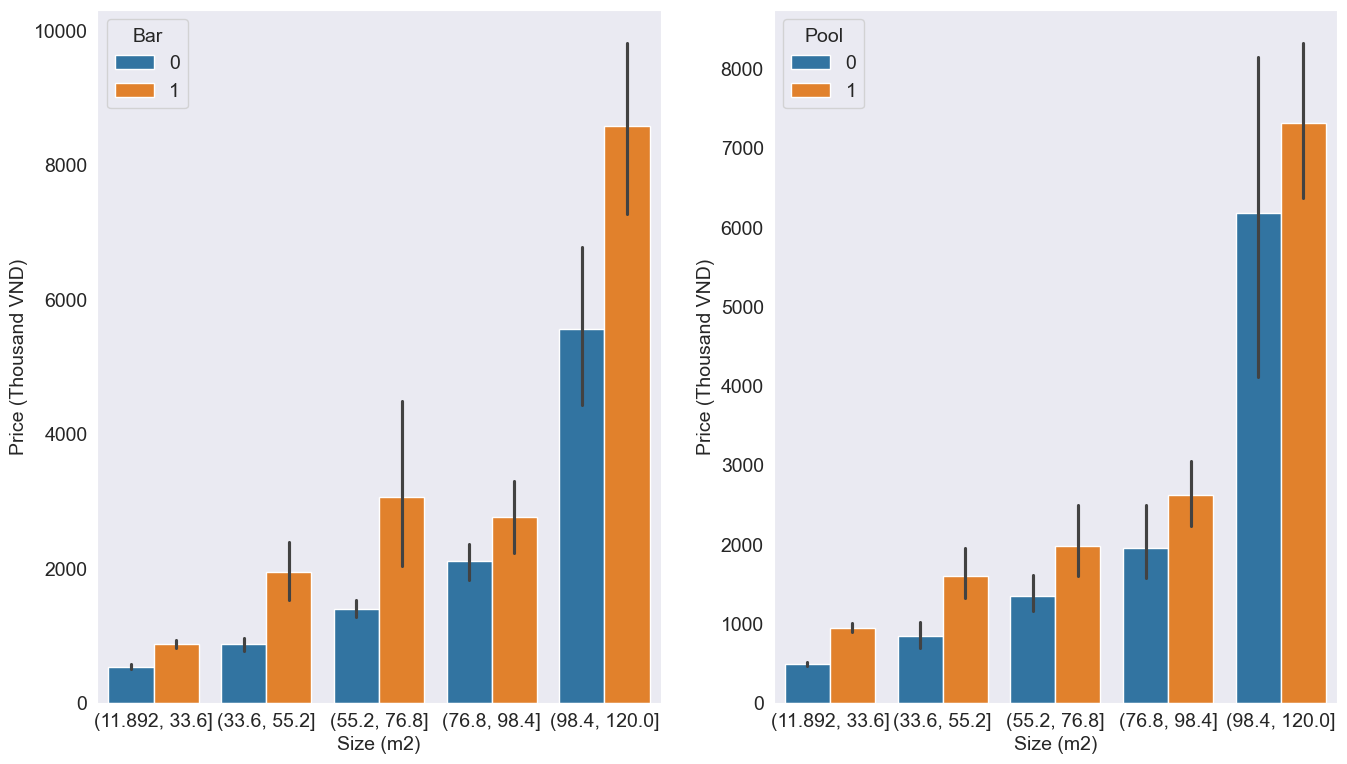

In [26]:
temp = data.copy()
temp["Size"] = pd.cut(temp["Size"], bins=5)

plt.rcParams.update({'font.size':14})
fig = plt.figure(figsize = (16, 9))
gs = gridspec.GridSpec(1, 2)

bars = fig.add_subplot(gs[0, 0])
sns.barplot(data=temp, x=temp["Size"], y="Price", hue = "Bar", ax = bars)
bars.set_xlabel("Size (m2)")
bars.set_ylabel("Price (Thousand VND)")

pools = fig.add_subplot(gs[0, 1])
sns.barplot(data=temp, x=temp["Size"], y="Price", hue = "Pool", ax = pools)
pools.set_xlabel("Size (m2)")
pools.set_ylabel("Price (Thousand VND)")

- It is clearly observed from the graph that within the same interval of room size, hotels have bar/pool are much more expensive

## 3D Distribution

### 

In [20]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=4,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'},{'type': 'scatter3d'},{'type': 'scatter3d'}]]
)

fig.add_trace(
    go.Scatter3d(
        x=data["Distance to beach"], 
        y=data["Size"],
        z=data["Price"], 
        mode='markers',
        marker=dict(
            size=7,
            color=data["Pool"],  
            colorscale='plasma',  
            opacity=0.5
        )
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter3d(
        x=data["Distance to beach"], 
        y=data["Size"],
        z=data["Price"], 
        mode='markers',
        marker=dict(
            size=7,
            color=data["Bar"],  
            colorscale='plasma',
            opacity=0.5
        )
    ),
    row=1, col=3
)

fig.show()

- Pools are more common than bars, this may lead to a higher correlation between pool to price than bar to price.
- Most of expensive hotels offer pools.


In [21]:
fig = px.scatter_3d(data,x="Distance to beach", y="Distance to airport",z = "Size", color = data["Price"], opacity=0.5)
plt.figure(figsize = (25, 16))
fig.show()

<Figure size 1800x1152 with 0 Axes>

- The majority of expensive hotels are near the beach
- It can be clearly seen from the graph that the price is more clearly differentiated by size than by the distance to the beach/airport.

## Using t-SNE to reduce the dimension of the graph

In [22]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(data[["Distance to beach","Size", "Distance to airport",  "Pool", "Bar"]])

In [23]:
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=data["Price"])
fig.show()

- There are 2 clear clusters represent 2 different groups of hotels: cheap and luxury.
- The clusters in the middle of the graph might represent the middle class of hotels, while the S-like clusters represent a higher group of hotels
- The high variance of these 2 clusters might be because of the variation in location and facilities of these hotels.

# Map of hotels in Danang
# ![title](map.png)

# Conclusion

- The majority of hotel prices in Danang fall in the range 250.000 - 1.000.000 VND
- Most of hotels in Danang are built closer to the beach rather than the airport
- Luxuries hotels are more likely to be located near the coastline than in the city centre
- Size of rooms has the largest impact on the price among the selected features
- Pool and bar are the top 2 facilities that should be available in high-end hotels